In [1]:
# resume_analysis_complete_enhanced.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from matplotlib.gridspec import GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
import joblib
import os
import time
import json
from catboost import CatBoostClassifier


In [2]:

# Create models directory
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)


In [3]:

# Load dataset
print("Loading dataset...")
resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')
resumeDataSet['cleaned_resume'] = ''
print(f" Dataset loaded: {resumeDataSet.shape}")


Loading dataset...
 Dataset loaded: (962, 3)


In [4]:

# Basic exploration
print("\n Dataset Overview:")
display(resumeDataSet.head())



 Dataset Overview:


,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",


In [5]:

print(f"\n Dataset Info:")
resumeDataSet.info()



 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        962 non-null    object
 1   Resume          962 non-null    object
 2   cleaned_resume  962 non-null    object
dtypes: object(3)
memory usage: 22.7+ KB


In [6]:

print(f"\n Categories: {resumeDataSet['Category'].nunique()}")



 Categories: 25


In [7]:

# Display category distribution
print("\n Category Distribution:")
category_counts = resumeDataSet['Category'].value_counts()
print(category_counts)



 Category Distribution:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64


In [8]:

# Enhanced Data Visualization - COMPREHENSIVE VISUALIZATIONS
print("\n Creating comprehensive visualizations...")

# 1. Category Distribution with Plotly (Enhanced)
fig = px.bar(
    x=category_counts.index, 
    y=category_counts.values,
    title="📊 Resume Category Distribution",
    labels={'x': 'Job Categories', 'y': 'Number of Resumes'},
    color=category_counts.values,
    color_continuous_scale='viridis'
)
fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False,
    height=500,
    template='plotly_white'
)
fig.show()


 Creating comprehensive visualizations...


In [9]:

# 2. Pie chart for category distribution
fig_pie = px.pie(
    values=category_counts.values,
    names=category_counts.index,
    title=" Category Distribution (Percentage)",
    hole=0.4,
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.update_layout(height=600)
fig_pie.show()


In [10]:

# 3. Category distribution treemap
fig_treemap = px.treemap(
    names=category_counts.index,
    parents=[''] * len(category_counts),
    values=category_counts.values,
    title='Category Distribution Treemap',
    color=category_counts.values,
    color_continuous_scale='Blues'
)
fig_treemap.update_layout(height=500)
fig_treemap.show()


In [11]:

# 4. Dataset statistics
stats_data = {
    'Metric': ['Total Resumes', 'Categories', 'Avg Words per Resume', 'Max Category', 'Min Category'],
    'Value': [
        len(resumeDataSet),
        len(category_counts),
        resumeDataSet['Resume'].apply(lambda x: len(str(x).split())).mean(),
        f"{category_counts.index[0]} ({category_counts.values[0]})",
        f"{category_counts.index[-1]} ({category_counts.values[-1]})"
    ]
}
stats_df = pd.DataFrame(stats_data)

fig_stats = go.Figure(data=[go.Table(
    header=dict(values=['Metric', 'Value'],
                fill_color='#1f77b4',
                align='left',
                font=dict(color='white', size=14)),
    cells=dict(values=[stats_df['Metric'], stats_df['Value']],
               fill_color='lavender',
               align='left'))
])
fig_stats.update_layout(title=' Dataset Statistics', height=300)
fig_stats.show()


In [12]:

# Text preprocessing function
def clean_resume_text(text):
    """Enhanced text cleaning function"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Remove special characters and numbers but keep some important symbols
    text = re.sub(r'[^a-zA-Z\s\+\#\.]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    return text.strip()

# Apply text cleaning
print("\n Cleaning resume text...")
resumeDataSet['cleaned_resume'] = resumeDataSet['Resume'].apply(clean_resume_text)

# Check text length distribution
resumeDataSet['text_length'] = resumeDataSet['cleaned_resume'].apply(len)
resumeDataSet['word_count'] = resumeDataSet['cleaned_resume'].apply(lambda x: len(x.split()))



 Cleaning resume text...


In [13]:

# Enhanced Text Analysis Visualizations
print("\n Analyzing text length distributions...")

# 5. Word count distribution
fig_length = px.histogram(
    resumeDataSet, 
    x='word_count',
    title=' Distribution of Word Count in Resumes',
    labels={'word_count': 'Word Count', 'count': 'Number of Resumes'},
    color_discrete_sequence=['#00A8E8'],
    nbins=50,
    template='plotly_white'
)
fig_length.update_layout(showlegend=False)
fig_length.show()



 Analyzing text length distributions...


In [14]:

# 6. Text length by category
fig_box = px.box(
    resumeDataSet,
    x='Category',
    y='word_count',
    title=' Word Count Distribution by Category',
    labels={'word_count': 'Word Count', 'Category': 'Job Category'},
    color='Category',
    template='plotly_white'
)
fig_box.update_layout(xaxis_tickangle=-45, height=600, showlegend=False)
fig_box.show()


In [15]:

# 7. Character count vs Word count scatter
fig_scatter = px.scatter(
    resumeDataSet,
    x='word_count',
    y='text_length',
    color='Category',
    title=' Word Count vs Character Count by Category',
    labels={'word_count': 'Word Count', 'text_length': 'Character Count'},
    template='plotly_white',
    hover_data=['Category']
)
fig_scatter.update_layout(height=500)
fig_scatter.show()


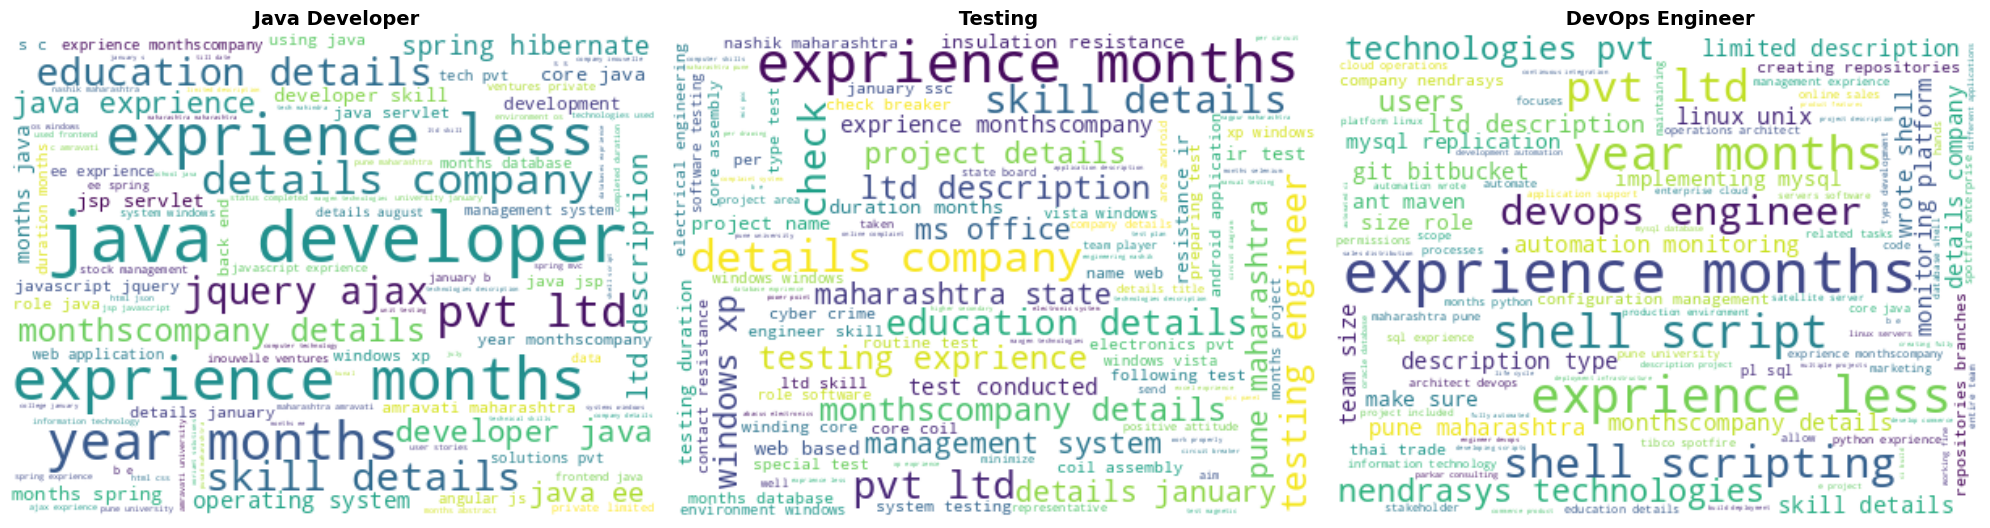

In [16]:

# 8. Top categories word cloud visualization
from wordcloud import WordCloud

# Combine all text for top 3 categories
top_categories = category_counts.head(3).index
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, category in enumerate(top_categories):
    category_text = ' '.join(resumeDataSet[resumeDataSet['Category'] == category]['cleaned_resume'])
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(category_text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f' {category}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [17]:

# Prepare features and labels
print("\n Preparing features and labels...")
X = resumeDataSet['cleaned_resume']
y = resumeDataSet['Category']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f" Features shape: {X.shape}")
print(f" Encoded labels shape: {y_encoded.shape}")
print(f" Number of classes: {len(label_encoder.classes_)}")



 Preparing features and labels...
 Features shape: (962,)
 Encoded labels shape: (962,)
 Number of classes: 25


In [18]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [19]:

print(f" Training set size: {X_train.shape[0]}")
print(f" Test set size: {X_test.shape[0]}")


 Training set size: 769
 Test set size: 193


In [20]:

# TF-IDF Vectorization with optimized parameters
print("\n Applying TF-IDF Vectorization...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f" TF-IDF features shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")



 Applying TF-IDF Vectorization...
 TF-IDF features shape - Train: (769, 5000), Test: (193, 5000)


In [21]:

# Save vectorizer and label encoder
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')
print(" Vectorizer and label encoder saved!")


 Vectorizer and label encoder saved!


In [22]:

# OPTIMIZED Model Training with CatBoost
print("\n Training Multiple Classifiers with Cross-Validation...")

# Define models with optimized parameters
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        C=1.0,
        solver='liblinear',
        n_jobs=-1
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=150,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ),
    'Support Vector Machine': SVC(
        kernel='linear',
        C=1.0,
        probability=True,
        random_state=42
    ),
    'Multinomial Naive Bayes': MultinomialNB(alpha=0.1),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}



 Training Multiple Classifiers with Cross-Validation...


In [23]:

# OPTIMIZED CatBoost model - faster training
catboost_model = CatBoostClassifier(
    iterations=300,  
    learning_rate=0.05,
    depth=6,  
    random_state=42,
    verbose=100,  # Show progress every 100 iterations
    thread_count=-1,  
    early_stopping_rounds=50,  
    task_type='CPU'
)


In [24]:

# Train models and evaluate
results = {}
training_times = {}
cv_scores = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds for speed

for name, model in models.items():
    print(f"\n Training {name}...")
    
    start_time = time.time()
    
    # Cross-validation
    cv_score = cross_val_score(model, X_train_tfidf, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = cv_score
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'cv_mean': cv_score.mean(),
        'cv_std': cv_score.std(),
        'training_time': training_time
    }
    
    print(f" {name} trained in {training_time:.2f}s")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   CV Score: {cv_score.mean():.4f} ± {cv_score.std():.4f}")



 Training Logistic Regression...
 Logistic Regression trained in 0.58s
   Accuracy: 0.9896
   Precision: 0.9904
   Recall: 0.9896
   F1-Score: 0.9897
   CV Score: 0.9870 ± 0.0066

 Training Random Forest...
 Random Forest trained in 1.97s
   Accuracy: 0.9948
   Precision: 0.9957
   Recall: 0.9948
   F1-Score: 0.9949
   CV Score: 0.9935 ± 0.0037

 Training Support Vector Machine...
 Support Vector Machine trained in 3.28s
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   CV Score: 0.9909 ± 0.0066

 Training Multinomial Naive Bayes...
 Multinomial Naive Bayes trained in 0.05s
   Accuracy: 0.9896
   Precision: 0.9911
   Recall: 0.9896
   F1-Score: 0.9896
   CV Score: 0.9831 ± 0.0037

 Training K-Nearest Neighbors...
 K-Nearest Neighbors trained in 5.16s
   Accuracy: 0.9845
   Precision: 0.9865
   Recall: 0.9845
   F1-Score: 0.9844
   CV Score: 0.9545 ± 0.0080


In [25]:

# Train CatBoost with progress tracking
print("\n Training CatBoost (Optimized for Speed)...")

# Convert to dense array for CatBoost (sample for faster training if needed)
if X_train_tfidf.shape[0] > 1000:
    # Use sampling for faster training on large datasets
    sample_indices = np.random.choice(X_train_tfidf.shape[0], 1000, replace=False)
    X_train_catboost = X_train_tfidf[sample_indices].toarray()
    y_train_catboost = y_train[sample_indices]
else:
    X_train_catboost = X_train_tfidf.toarray()
    y_train_catboost = y_train

X_test_catboost = X_test_tfidf.toarray()

start_time = time.time()

try:
    catboost_model.fit(
        X_train_catboost, 
        y_train_catboost,
        eval_set=(X_test_catboost, y_test),
        verbose=100,
        plot=False  # Set to True to see training plots
    )
    
    training_time_cb = time.time() - start_time
    y_pred_cb = catboost_model.predict(X_test_catboost)
    y_pred_proba_cb = catboost_model.predict_proba(X_test_catboost)
    
    accuracy_cb = accuracy_score(y_test, y_pred_cb)
    precision_cb = precision_score(y_test, y_pred_cb, average='weighted', zero_division=0)
    recall_cb = recall_score(y_test, y_pred_cb, average='weighted', zero_division=0)
    f1_cb = f1_score(y_test, y_pred_cb, average='weighted', zero_division=0)
    
    # Cross-validation for CatBoost
    cv_score_cb = cross_val_score(catboost_model, X_train_catboost, y_train_catboost, cv=2, scoring='accuracy')
    
    results['CatBoost'] = {
        'model': catboost_model,
        'accuracy': accuracy_cb,
        'precision': precision_cb,
        'recall': recall_cb,
        'f1_score': f1_cb,
        'predictions': y_pred_cb,
        'probabilities': y_pred_proba_cb,
        'cv_mean': cv_score_cb.mean(),
        'cv_std': cv_score_cb.std(),
        'training_time': training_time_cb
    }
    
    print(f" CatBoost trained in {training_time_cb:.2f}s")
    print(f"   Accuracy: {accuracy_cb:.4f}")
    print(f"   Precision: {precision_cb:.4f}")
    print(f"   Recall: {recall_cb:.4f}")
    print(f"   F1-Score: {f1_cb:.4f}")
    print(f"   CV Score: {cv_score_cb.mean():.4f} ± {cv_score_cb.std():.4f}")

except Exception as e:
    print(f" CatBoost training failed: {e}")
    print(" Continuing with other models...")



 Training CatBoost (Optimized for Speed)...
0:	learn: 3.1361170	test: 3.1403504	best: 3.1403504 (0)	total: 539ms	remaining: 2m 41s
100:	learn: 0.7545714	test: 0.8231835	best: 0.8231835 (100)	total: 32.7s	remaining: 1m 4s
200:	learn: 0.2391848	test: 0.2763204	best: 0.2763204 (200)	total: 1m 5s	remaining: 32s
299:	learn: 0.1015463	test: 0.1236213	best: 0.1236213 (299)	total: 1m 37s	remaining: 0us

bestTest = 0.123621328
bestIteration = 299

0:	learn: 3.1845670	total: 242ms	remaining: 1m 12s
100:	learn: 1.1815739	total: 26.1s	remaining: 51.4s
200:	learn: 0.4237516	total: 51.8s	remaining: 25.5s
299:	learn: 0.2029618	total: 1m 17s	remaining: 0us
0:	learn: 3.1948741	total: 238ms	remaining: 1m 11s
100:	learn: 1.2265836	total: 25.3s	remaining: 49.8s
200:	learn: 0.4334509	total: 50.1s	remaining: 24.7s
299:	learn: 0.2014021	total: 1m 15s	remaining: 0us
 CatBoost trained in 99.64s
   Accuracy: 0.9948
   Precision: 0.9957
   Recall: 0.9948
   F1-Score: 0.9949
   CV Score: 0.9948 ± 0.0026


In [26]:

# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'CV_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()],
    'Training_Time': [results[name]['training_time'] for name in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\n Model Performance Summary:")
display(results_df)



 Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1-Score,CV_Mean,CV_Std,Training_Time
2,Support Vector Machine,1.000000,1.000000,1.000000,1.000000,0.990885,0.006639,3.279893
1,Random Forest,0.994819,0.995682,0.994819,0.994931,0.993495,0.003686,1.966982
5,CatBoost,0.994819,0.995682,0.994819,0.994931,0.994802,0.002594,99.638301
0,Logistic Regression,0.989637,0.990377,0.989637,0.989713,0.986984,0.006646,0.578626
3,Multinomial Naive Bayes,0.989637,0.991118,0.989637,0.989625,0.983088,0.003704,0.053419
4,K-Nearest Neighbors,0.984456,0.986512,0.984456,0.984396,0.954488,0.008017,5.162138


In [27]:

# COMPREHENSIVE MODEL VISUALIZATIONS
print("\n Creating comprehensive model visualizations...")

# 9. Model Performance Radar Chart
categories_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig_radar = go.Figure()

for model_name in results.keys():
    if model_name in results:
        model_results = results[model_name]
        fig_radar.add_trace(go.Scatterpolar(
            r=[
                model_results['accuracy'],
                model_results['precision'], 
                model_results['recall'],
                model_results['f1_score']
            ],
            theta=categories_radar,
            fill='toself',
            name=model_name
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title=" Model Performance Radar Chart",
    template='plotly_white',
    height=500
)
fig_radar.show()



 Creating comprehensive model visualizations...


In [28]:

# 10. Model Performance Comparison
fig_performance = px.bar(
    results_df,
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    title=' Model Performance Metrics Comparison',
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig_performance.update_layout(
    xaxis_tickangle=-45,
    height=500,
    template='plotly_white'
)
fig_performance.show()


In [29]:

# 11. Training Time Comparison
fig_time = px.bar(
    results_df,
    x='Model',
    y='Training_Time',
    title=' Model Training Time Comparison (Seconds)',
    color='Training_Time',
    color_continuous_scale='viridis'
)

fig_time.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white'
)
fig_time.show()


In [30]:

# 12. Cross-Validation Scores Comparison
cv_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_Score': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()]
})

fig_cv = px.bar(
    cv_comparison,
    x='Model',
    y='CV_Score',
    error_y='CV_Std',
    title=' Cross-Validation Scores with Standard Deviation',
    color='CV_Score',
    color_continuous_scale='blues'
)

fig_cv.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    height=500
)
fig_cv.show()


In [31]:

# 13. Performance Metrics Heatmap
metrics_heatmap = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].set_index(results_df['Model'])
fig_heatmap = px.imshow(
    metrics_heatmap,
    text_auto=True,
    aspect="auto",
    title=' Model Performance Heatmap',
    color_continuous_scale='viridis'
)

fig_heatmap.update_layout(height=400)
fig_heatmap.show()


In [32]:

# 14. Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n Best Performing Model: {best_model_name}")

cm = confusion_matrix(y_test, best_predictions)
fig_cm = px.imshow(
    cm,
    text_auto=True,
    aspect="auto",
    title=f' Confusion Matrix - {best_model_name}',
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=label_encoder.classes_,
    y=label_encoder.classes_,
    color_continuous_scale='blues'
)

fig_cm.update_layout(height=700)
fig_cm.show()



 Best Performing Model: Support Vector Machine


In [33]:

# 15. Classification Report Heatmap
class_report = classification_report(y_test, best_predictions, 
                                   target_names=label_encoder.classes_, 
                                   output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

fig_report = px.imshow(
    class_report_df.iloc[:-1, :-1],
    text_auto=True,
    aspect="auto",
    title=f' Classification Report - {best_model_name}',
    color_continuous_scale='viridis'
)

fig_report.update_layout(height=600)
fig_report.show()


In [34]:

# 16. Feature Importance (for tree-based models)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    
    # Get top 20 features
    top_indices = np.argsort(feature_importance)[-20:][::-1]
    feature_names = tfidf_vectorizer.get_feature_names_out()
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    fig_importance = px.bar(
        x=top_importance,
        y=top_features,
        orientation='h',
        title=' Top 20 Most Important Features (Random Forest)',
        labels={'x': 'Importance', 'y': 'Features'},
        color=top_importance,
        color_continuous_scale='viridis'
    )
    
    fig_importance.update_layout(
        showlegend=False, 
        height=500,
        template='plotly_white'
    )
    fig_importance.show()


In [35]:

# Save all models
print("\n Saving trained models...")

for name, result in results.items():
    model = result['model']
    
    try:
        if name == 'CatBoost':
            # Save CatBoost in its native format
            model.save_model('models/catboost_model.cbm')
        else:
            # Save other models with joblib
            joblib.dump(model, f'models/{name.lower().replace(" ", "_")}_model.pkl')
        
        print(f" {name} model saved successfully!")
        
    except Exception as e:
        print(f" Could not save {name}: {e}")

print("\n Model training and evaluation completed!")
print(f" Best model: {best_model_name} with {results[best_model_name]['accuracy']:.4f} accuracy")



 Saving trained models...
 Logistic Regression model saved successfully!
 Random Forest model saved successfully!
 Support Vector Machine model saved successfully!
 Multinomial Naive Bayes model saved successfully!
 K-Nearest Neighbors model saved successfully!
 CatBoost model saved successfully!

 Model training and evaluation completed!
 Best model: Support Vector Machine with 1.0000 accuracy


In [36]:

# Final Comprehensive Summary
print("\n" + "="*70)
print(" COMPREHENSIVE RESUME ANALYSIS SYSTEM READY!")
print("="*70)

print(f"\n Final Model Performance Ranking:")
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"   {i:2d}. {row['Model']:25} Accuracy: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} | Time: {row['Training_Time']:.1f}s")

print(f"\n Dataset Statistics:")
print(f"    Total resumes: {len(resumeDataSet):,}")
print(f"    Categories: {len(label_encoder.classes_)}")
print(f"    Training samples: {len(X_train):,}")
print(f"    Test samples: {len(X_test):,}")
print(f"    Feature dimension: {X_train_tfidf.shape[1]:,}")

print(f"\n Models saved in 'models/' directory:")
saved_models = [f for f in os.listdir('models') if f.endswith(('.pkl', '.cbm'))]
for model_file in saved_models:
    file_size = os.path.getsize(f'models/{model_file}') / 1024 / 1024
    print(f"    {model_file:45} ({file_size:.1f} MB)")

print(f"\n Next steps:")
print("   1. Use the trained models in your Streamlit app")
print("   2. Implement resume analysis and job matching features")
print("   3. Add XAI explanations for predictions")
print("   4. Deploy the complete system")

print("="*70)


 COMPREHENSIVE RESUME ANALYSIS SYSTEM READY!

 Final Model Performance Ranking:
    1. Support Vector Machine    Accuracy: 1.0000 | F1: 1.0000 | Time: 3.3s
    2. Random Forest             Accuracy: 0.9948 | F1: 0.9949 | Time: 2.0s
    3. CatBoost                  Accuracy: 0.9948 | F1: 0.9949 | Time: 99.6s
    4. Logistic Regression       Accuracy: 0.9896 | F1: 0.9897 | Time: 0.6s
    5. Multinomial Naive Bayes   Accuracy: 0.9896 | F1: 0.9896 | Time: 0.1s
    6. K-Nearest Neighbors       Accuracy: 0.9845 | F1: 0.9844 | Time: 5.2s

 Dataset Statistics:
    Total resumes: 962
    Categories: 25
    Training samples: 769
    Test samples: 193
    Feature dimension: 5,000

 Models saved in 'models/' directory:
    catboost_model.cbm                            (3.9 MB)
    k-nearest_neighbors_model.pkl                 (1.6 MB)
    label_encoder.pkl                             (0.0 MB)
    logistic_regression_model.pkl                 (1.0 MB)
    multinomial_naive_bayes_model.pkl         

In [37]:
# Add this section after the model training and before the final summary

print("\n Implementing Complete Resume Analysis System with XAI...")

# Enhanced Resume Analysis Functions with XAI
class ResumeAnalyzer:
    def __init__(self, vectorizer, label_encoder, models, resumes_df):
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
        self.models = models
        self.stop_words = set(stopwords.words('english'))
        self.resumes_df = resumes_df
        
        # Extract skills dynamically from resumes
        print(" Extracting skills from resumes...")
        self.skill_patterns = self._extract_skills_from_resumes()
        print(f" Extracted {sum(len(skills) for skills in self.skill_patterns.values())} unique skills across {len(self.skill_patterns)} categories")
    
    def _extract_skills_from_resumes(self):
        """Extract skills dynamically from all resumes using NLP techniques"""
        all_text = ' '.join(self.resumes_df['cleaned_resume'].astype(str))
        
        # Extract technical terms and tools using multiple patterns
        skill_categories = {
            'programming_languages': [],
            'frameworks_tools': [],
            'databases': [],
            'cloud_platforms': [],
            'soft_skills': [],
            'methodologies': []
        }
        
        # Pattern 1: Extract words with specific technical patterns
        technical_patterns = [
            r'\b[a-z]+(?:\+{1,2}|\#)\b',  # C++, C#, etc.
            r'\b(?:python|java|javascript|ruby|php|swift|kotlin|go|rust|scala|r|matlab)\b',
            r'\b(?:html|css|sql|nosql|xml|json|yaml)\b',
            r'\b(?:react|angular|vue|django|flask|spring|laravel|rails|express|node\.js)\b',
            r'\b(?:pandas|numpy|tensorflow|pytorch|keras|scikit-learn|spark|hadoop)\b',
            r'\b(?:aws|azure|gcp|docker|kubernetes|jenkins|terraform|ansible|git)\b',
            r'\b(?:mysql|postgresql|mongodb|redis|oracle|sqlite|cassandra|dynamodb)\b',
            r'\b(?:tableau|power\s*bi|excel|jira|confluence|slack|figma)\b'
        ]
        
        for pattern in technical_patterns:
            matches = re.findall(pattern, all_text.lower())
            for match in matches:
                if len(match) > 2:  # Filter out very short matches
                    # Categorize based on patterns
                    if any(tech in match for tech in ['python', 'java', 'javascript', 'c++', 'c#', 'ruby', 'php', 'swift', 'kotlin', 'go', 'rust', 'scala', 'r', 'matlab']):
                        if match not in skill_categories['programming_languages']:
                            skill_categories['programming_languages'].append(match)
                    elif any(fw in match for fw in ['react', 'angular', 'vue', 'django', 'flask', 'spring', 'laravel', 'rails', 'express', 'node']):
                        if match not in skill_categories['frameworks_tools']:
                            skill_categories['frameworks_tools'].append(match)
                    elif any(db in match for db in ['mysql', 'postgresql', 'mongodb', 'redis', 'oracle', 'sqlite', 'cassandra', 'dynamodb']):
                        if match not in skill_categories['databases']:
                            skill_categories['databases'].append(match)
                    elif any(cloud in match for cloud in ['aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'terraform', 'ansible']):
                        if match not in skill_categories['cloud_platforms']:
                            skill_categories['cloud_platforms'].append(match)
                    elif any(tool in match for tool in ['tableau', 'power bi', 'excel', 'jira', 'confluence', 'slack', 'figma']):
                        if match not in skill_categories['frameworks_tools']:
                            skill_categories['frameworks_tools'].append(match)
        
        # Pattern 2: Extract skills from common phrases
        skill_phrases = [
            r'(?:proficient in|experienced with|knowledge of|skills in)\s+([a-zA-Z\s\+#]+?)(?:\s|\.|,)',
            r'(?:expertise in|strong background in)\s+([a-zA-Z\s\+#]+?)(?:\s|\.|,)',
            r'(?:working knowledge of|familiar with)\s+([a-zA-Z\s\+#]+?)(?:\s|\.|,)'
        ]
        
        for phrase in skill_phrases:
            matches = re.findall(phrase, all_text.lower())
            for match in matches:
                skills = [skill.strip() for skill in match.split() if len(skill.strip()) > 2]
                for skill in skills:
                    if skill not in self.stop_words and not skill.isdigit():
                        # Add to appropriate category or frameworks_tools as default
                        if skill not in skill_categories['frameworks_tools']:
                            skill_categories['frameworks_tools'].append(skill)
        
        # Pattern 3: Extract soft skills
        soft_skill_patterns = [
            r'\b(?:communication|leadership|teamwork|problem solving|critical thinking|creativity|adaptability|time management|project management|agile|scrum|kanban)\b',
            r'\b(?:collaboration|presentation|negotiation|decision making|strategic planning|analytical thinking)\b'
        ]
        
        for pattern in soft_skill_patterns:
            matches = re.findall(pattern, all_text.lower())
            for match in matches:
                if match not in skill_categories['soft_skills']:
                    skill_categories['soft_skills'].append(match)
        
        # Pattern 4: Extract methodologies
        methodology_patterns = [
            r'\b(?:agile|scrum|kanban|waterfall|devops|ci/cd|tdd|test driven development|lean|six sigma)\b'
        ]
        
        for pattern in methodology_patterns:
            matches = re.findall(pattern, all_text.lower())
            for match in matches:
                if match not in skill_categories['methodologies']:
                    skill_categories['methodologies'].append(match)
        
        # Remove empty categories and sort skills
        final_categories = {}
        for category, skills in skill_categories.items():
            if skills:
                final_categories[category] = sorted(list(set(skills)))
        
        return final_categories
    
    def extract_skills(self, text):
        """Extract skills from text using dynamically learned patterns"""
        skills_found = {category: [] for category in self.skill_patterns.keys()}
        text_lower = text.lower()
        
        for category, skill_list in self.skill_patterns.items():
            for skill in skill_list:
                # Use word boundaries to avoid partial matches
                pattern = r'\b' + re.escape(skill) + r'\b'
                if re.search(pattern, text_lower):
                    skills_found[category].append(skill)
        
        return skills_found
    
    def analyze_resume_structure(self, text):
        """Analyze resume structure and quality with enhanced metrics"""
        analysis = {}
        
        # Word count analysis
        words = text.split()
        analysis['word_count'] = len(words)
        analysis['character_count'] = len(text)
        
        # Section detection with enhanced patterns
        sections = {
            'experience': len(re.findall(r'\b(experience|work\s*history|employment|professional\s*experience)\b', text, re.I)),
            'education': len(re.findall(r'\b(education|academic|degree|qualification|certification)\b', text, re.I)),
            'skills': len(re.findall(r'\b(skills|technical\s*skills|competencies|expertise)\b', text, re.I)),
            'projects': len(re.findall(r'\b(projects|portfolio|work\s*samples|achievements)\b', text, re.I)),
            'summary': len(re.findall(r'\b(summary|objective|profile|about)\b', text, re.I))
        }
        
        analysis['sections_found'] = {k: v > 0 for k, v in sections.items()}
        analysis['missing_sections'] = [k for k, v in analysis['sections_found'].items() if not v]
        analysis['section_count'] = sum(analysis['sections_found'].values())
        
        # Quality indicators
        analysis['has_quantifiable_achievements'] = bool(re.search(r'\d+%|\$\d+|\d+\+|\d+\s*(?:years|months)', text))
        analysis['has_action_verbs'] = bool(re.search(r'\b(developed|managed|implemented|created|led|improved|increased|reduced|optimized)\b', text, re.I))
        analysis['has_contact_info'] = bool(re.search(r'\b[\w\.-]+@[\w\.-]+\.\w+\b|\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', text))
        
        # Readability metrics
        sentences = re.split(r'[.!?]+', text)
        analysis['sentence_count'] = len([s for s in sentences if len(s.strip()) > 0])
        analysis['avg_sentence_length'] = analysis['word_count'] / max(analysis['sentence_count'], 1)
        
        return analysis
    
    def predict_with_xai(self, text):
        """Make prediction with Explainable AI features"""
        if not text or len(text.strip()) < 50:
            return {'error': 'Text too short (minimum 50 characters required)'}
        
        # Clean and vectorize text
        cleaned_text = clean_resume_text(text)
        features = self.vectorizer.transform([cleaned_text])
        
        # Get predictions from all models with XAI
        model_predictions = {}
        model_probabilities = {}
        model_confidences = {}
        
        for name, model in self.models.items():
            try:
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(features)[0]
                    pred = model.predict(features)[0]
                    pred_category = self.label_encoder.inverse_transform([pred])[0]
                    
                    model_predictions[name] = pred_category
                    model_probabilities[name] = proba
                    model_confidences[name] = float(proba[pred])
                else:
                    pred = model.predict(features)[0]
                    pred_category = self.label_encoder.inverse_transform([pred])[0]
                    model_predictions[name] = pred_category
                    model_confidences[name] = 0.5  # Default confidence for non-probabilistic models
            except Exception as e:
                print(f" {name} prediction failed: {e}")
                continue
        
        # Ensemble prediction (weighted average of probabilities)
        if model_probabilities:
            avg_prob = np.mean(list(model_probabilities.values()), axis=0)
            final_pred_idx = np.argmax(avg_prob)
            final_pred = self.label_encoder.inverse_transform([final_pred_idx])[0]
            confidence = float(avg_prob[final_pred_idx])
            
            # Get top 3 categories with confidence scores
            top_3_indices = np.argsort(avg_prob)[-3:][::-1]
            top_categories = []
            for idx in top_3_indices:
                category = self.label_encoder.inverse_transform([idx])[0]
                prob = float(avg_prob[idx])
                top_categories.append({'category': category, 'confidence': prob})
        else:
            # Fallback to most common prediction
            final_pred = max(set(model_predictions.values()), key=list(model_predictions.values()).count)
            confidence = np.mean(list(model_confidences.values())) if model_confidences else 0.5
            top_categories = [{'category': final_pred, 'confidence': confidence}]
        
        # Model consensus analysis
        consensus_analysis = {
            'agreement_level': self._calculate_model_agreement(model_predictions),
            'confident_models': [name for name, conf in model_confidences.items() if conf > 0.7],
            'uncertain_models': [name for name, conf in model_confidences.items() if conf < 0.5]
        }
        
        # Extract skills and structure
        skills = self.extract_skills(text)
        structure = self.analyze_resume_structure(text)
        
        # Feature importance explanation (for tree-based models)
        feature_explanation = self._explain_prediction(cleaned_text, final_pred_idx) if model_probabilities else {}
        
        return {
            'predicted_category': final_pred,
            'confidence': confidence,
            'model_consensus': model_predictions,
            'model_confidences': model_confidences,
            'consensus_analysis': consensus_analysis,
            'top_categories': top_categories,
            'skills': skills,
            'resume_structure': structure,
            'feature_explanation': feature_explanation,
            'word_count': len(cleaned_text.split()),
            'processing_details': {
                'models_used': len(model_predictions),
                'ensemble_method': 'weighted_probability_average',
                'successful_predictions': len(model_predictions)
            }
        }
    
    def _calculate_model_agreement(self, model_predictions):
        """Calculate how much models agree on the prediction"""
        if not model_predictions:
            return 0.0
        
        predictions = list(model_predictions.values())
        most_common = max(set(predictions), key=predictions.count)
        agreement = predictions.count(most_common) / len(predictions)
        return agreement
    
    def _explain_prediction(self, text, predicted_idx):
        """Provide feature-based explanation for prediction"""
        explanation = {
            'key_terms': [],
            'decision_factors': []
        }
        
        # Extract important words from the text that match feature names
        feature_names = self.vectorizer.get_feature_names_out()
        words = text.lower().split()
        
        # Find overlapping terms with feature names
        important_terms = [word for word in words if word in feature_names]
        explanation['key_terms'] = important_terms[:10]  # Top 10 terms
        
        # Simple explanation based on category
        predicted_category = self.label_encoder.inverse_transform([predicted_idx])[0]
        explanation['decision_factors'].append(f"Contains terms commonly found in {predicted_category} resumes")
        
        return explanation
    
    def generate_feedback(self, xai_result):
        """Generate actionable feedback based on XAI analysis"""
        feedback = {
            'strengths': [],
            'improvements': [],
            'suggestions': [],
            'xai_insights': []
        }
        
        pred_category = xai_result['predicted_category']
        skills = xai_result['skills']
        structure = xai_result['resume_structure']
        confidence = xai_result['confidence']
        consensus = xai_result['consensus_analysis']
        
        # XAI Insights
        feedback['xai_insights'].append(f"Model Confidence: {confidence:.1%}")
        feedback['xai_insights'].append(f"Model Agreement: {consensus['agreement_level']:.1%}")
        
        if confidence < 0.6:
            feedback['xai_insights'].append("Low confidence - consider making your skills more specific")
        else:
            feedback['xai_insights'].append("High confidence - your resume clearly matches this category")
        
        # Confidence-based feedback
        if confidence < 0.5:
            feedback['improvements'].append("Low prediction confidence. Make your skills and experience more specific to your target role.")
        elif confidence < 0.7:
            feedback['improvements'].append("Moderate confidence. Consider tailoring your resume more specifically to your desired category.")
        else:
            feedback['strengths'].append("High prediction confidence - your resume strongly aligns with this category.")
        
        # Skills feedback
        total_skills = sum(len(skill_list) for skill_list in skills.values())
        if total_skills < 5:
            feedback['improvements'].append(f"Only {total_skills} skills detected. Add more specific technical skills relevant to {pred_category}.")
        elif total_skills < 15:
            feedback['strengths'].append(f"Good skill diversity ({total_skills} skills detected).")
        else:
            feedback['strengths'].append(f"Excellent skill diversity ({total_skills} skills detected).")
        
        # Structure feedback
        if structure['missing_sections']:
            feedback['improvements'].append(f"Consider adding these sections: {', '.join(structure['missing_sections'])}")
        
        if not structure['has_quantifiable_achievements']:
            feedback['improvements'].append("Add quantifiable achievements (numbers, percentages, metrics) to demonstrate impact.")
        
        if not structure['has_action_verbs']:
            feedback['improvements'].append("Use more action verbs (developed, managed, implemented, led) to describe achievements.")
        
        if not structure['has_contact_info']:
            feedback['improvements'].append("Ensure contact information (email, phone) is included.")
        
        # Category-specific suggestions
        category_suggestions = self._get_category_specific_suggestions(pred_category, skills)
        feedback['suggestions'].extend(category_suggestions)
        
        # Alternative career paths
        if len(xai_result['top_categories']) > 1:
            alt_careers = [f"{cat['category']} ({cat['confidence']:.1%})" for cat in xai_result['top_categories'][1:3]]
            feedback['suggestions'].append(f"Also consider: {', '.join(alt_careers)}")
        
        return feedback
    
    def _get_category_specific_suggestions(self, category, skills):
        """Generate category-specific improvement suggestions"""
        suggestions = []
        
        base_suggestions = {
            'Data Science': [
                "Highlight specific ML algorithms and frameworks",
                "Include data visualization projects and metrics",
                "Mention statistical analysis and hypothesis testing",
                "Showcase big data technologies if applicable"
            ],
            'Java Developer': [
                "Specify Java versions and frameworks (Spring, Hibernate)",
                "Mention microservices architecture experience",
                "Include build tools and CI/CD pipeline experience",
                "Highlight performance optimization experience"
            ],
            'Web Designing': [
                "Showcase responsive design projects",
                "Include specific frameworks and libraries used",
                "Mention UI/UX design principles and tools",
                "Add portfolio links or project examples"
            ],
            'HR': [
                "Quantify recruitment metrics and achievements",
                "Mention specific HRIS systems experience",
                "Highlight employee engagement initiatives",
                "Showcase compliance and legal knowledge"
            ],
            'DevOps Engineer': [
                "Detail CI/CD pipeline implementations",
                "Mention specific cloud platforms and services",
                "Include infrastructure as code experience",
                "Highlight monitoring and logging solutions"
            ]
        }
        
        if category in base_suggestions:
            suggestions.extend(base_suggestions[category])
        else:
            suggestions.extend([
                "Highlight your most relevant projects and achievements",
                "Use action verbs to describe your responsibilities",
                "Quantify your achievements with numbers and metrics",
                "Include relevant certifications and education"
            ])
        
        return suggestions



 Implementing Complete Resume Analysis System with XAI...


In [38]:

# Job Description Analysis Component
class JobDescriptionAnalyzer:
    def __init__(self, resume_analyzer):
        self.resume_analyzer = resume_analyzer
    
    def analyze_job_description(self, job_description):
        """Analyze job description and extract key requirements with XAI"""
        analysis = self.resume_analyzer.predict_with_xai(job_description)
        
        # Extract key requirements
        skills = self.resume_analyzer.extract_skills(job_description)
        
        # Find important keywords (excluding common words)
        words = job_description.lower().split()
        word_freq = {}
        for word in words:
            if len(word) > 3 and word not in self.resume_analyzer.stop_words and word.isalpha():
                word_freq[word] = word_freq.get(word, 0) + 1
        
        # Get top keywords
        top_keywords = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
        
        analysis['top_keywords'] = [word for word, freq in top_keywords]
        analysis['key_requirements'] = skills
        analysis['word_frequency'] = dict(top_keywords)
        
        return analysis
    
    def match_resume_to_job(self, resume_text, job_description):
        """Match resume to job description and provide compatibility score with XAI"""
        resume_analysis = self.resume_analyzer.predict_with_xai(resume_text)
        job_analysis = self.analyze_job_description(job_description)
        
        # Calculate skill match
        resume_skills = set()
        for category_skills in resume_analysis['skills'].values():
            resume_skills.update(category_skills)
        
        job_skills = set()
        for category_skills in job_analysis['key_requirements'].values():
            job_skills.update(category_skills)
        
        common_skills = resume_skills.intersection(job_skills)
        missing_skills = job_skills - resume_skills
        extra_skills = resume_skills - job_skills
        
        # Calculate match scores
        skill_match = len(common_skills) / len(job_skills) if job_skills else 0
        category_match = 1.0 if resume_analysis['predicted_category'] == job_analysis['predicted_category'] else 0.3
        
        # Keyword overlap
        resume_words = set(resume_text.lower().split())
        job_keywords = set(job_analysis['top_keywords'])
        keyword_overlap = len(resume_words.intersection(job_keywords)) / len(job_keywords) if job_keywords else 0
        
        # Overall match score (weighted average)
        overall_match = (skill_match * 0.5 + category_match * 0.3 + keyword_overlap * 0.2)
        
        # XAI insights for matching
        match_insights = []
        if skill_match > 0.7:
            match_insights.append("Excellent skill alignment with job requirements")
        elif skill_match > 0.5:
            match_insights.append("Good skill match with some gaps")
        else:
            match_insights.append("Significant skill gaps identified")
        
        if category_match == 1.0:
            match_insights.append("Perfect category alignment")
        else:
            match_insights.append("Different career categories - consider tailoring your resume")
        
        return {
            'overall_match': overall_match,
            'skill_match': skill_match,
            'category_match': category_match,
            'keyword_match': keyword_overlap,
            'common_skills': list(common_skills),
            'missing_skills': list(missing_skills),
            'extra_skills': list(extra_skills),
            'match_insights': match_insights,
            'resume_analysis': resume_analysis,
            'job_analysis': job_analysis,
            'match_breakdown': {
                'skills_weight': 0.5,
                'category_weight': 0.3,
                'keywords_weight': 0.2
            }
        }


In [39]:

# Initialize the analysis system
print(" Initializing Resume Analysis System...")
resume_analyzer = ResumeAnalyzer(tfidf_vectorizer, label_encoder, 
                               {name: results[name]['model'] for name in results},
                               resumeDataSet)

job_analyzer = JobDescriptionAnalyzer(resume_analyzer)
print(" Resume Analysis System with XAI initialized!")

# Test the complete system
print("\n Testing Complete Resume Analysis System...")


 Initializing Resume Analysis System...
 Extracting skills from resumes...
 Extracted 111 unique skills across 6 categories
 Resume Analysis System with XAI initialized!

 Testing Complete Resume Analysis System...


In [40]:

# Sample resume text for testing
sample_resume = """
John Doe
Data Scientist
5+ years experience in machine learning and data analysis

SKILLS:
Python, Pandas, NumPy, Scikit-learn, TensorFlow, SQL, Tableau, AWS
Machine Learning, Deep Learning, Data Visualization, Statistics, Big Data

EXPERIENCE:
Senior Data Scientist at Tech Company (2019-Present)
- Developed ML models that improved prediction accuracy by 25%
- Managed team of 3 junior data scientists
- Implemented end-to-end data pipelines serving 1M+ users
- Reduced processing time by 40% through optimization

EDUCATION:
MS in Computer Science, University of Example
BS in Statistics, Another University

PROJECTS:
- Customer churn prediction model with 90% accuracy
- Real-time recommendation system using collaborative filtering
- Big data analysis using Spark and Hadoop

CERTIFICATIONS:
- AWS Certified Data Analytics
- Google Cloud Professional Data Engineer
"""

# Test resume analysis with XAI
print("📄 Testing Resume Analysis with XAI...")
resume_result = resume_analyzer.predict_with_xai(sample_resume)

print(f" Predicted Category: {resume_result['predicted_category']}")
print(f" Confidence: {resume_result['confidence']:.2%}")
print(f" Model Agreement: {resume_result['consensus_analysis']['agreement_level']:.1%}")
print(f" Skills Detected: {sum(len(skills) for skills in resume_result['skills'].values())}")


📄 Testing Resume Analysis with XAI...
 Predicted Category: Data Science
 Confidence: 56.80%
 Model Agreement: 100.0%
 Skills Detected: 7


In [41]:

# Display model consensus
print(f" Model Consensus:")
for model, prediction in resume_result['model_consensus'].items():
    confidence = resume_result['model_confidences'].get(model, 0.5)
    print(f"   - {model}: {prediction} ({confidence:.1%})")

# Test feedback generation
feedback = resume_analyzer.generate_feedback(resume_result)
print(f" XAI Feedback Generated:")
print(f"   - Strengths: {len(feedback['strengths'])}")
print(f"   - Improvements: {len(feedback['improvements'])}")
print(f"   - Suggestions: {len(feedback['suggestions'])}")
print(f"   - Insights: {len(feedback['xai_insights'])}")


 Model Consensus:
   - Logistic Regression: Data Science (34.6%)
   - Random Forest: Data Science (28.6%)
   - Support Vector Machine: Data Science (42.0%)
   - Multinomial Naive Bayes: Data Science (99.8%)
   - K-Nearest Neighbors: Data Science (100.0%)
   - CatBoost: Data Science (35.8%)
 XAI Feedback Generated:
   - Strengths: 1
   - Improvements: 3
   - Suggestions: 5
   - Insights: 3


In [42]:

# Test job matching
sample_job_description = """
Data Scientist Position

We are looking for an experienced Data Scientist with strong Python skills and expertise in machine learning. 

Required Qualifications:
- 3+ years experience in data science and machine learning
- Proficiency in Python, Pandas, NumPy, Scikit-learn, TensorFlow
- Experience with SQL and data visualization tools (Tableau, Power BI)
- Strong statistical background and analytical skills
- Experience with big data technologies (Spark, Hadoop)
- AWS cloud services experience
- Excellent communication and teamwork skills

Preferred Qualifications:
- Experience with deep learning and neural networks
- Knowledge of natural language processing
- Experience with CI/CD pipelines
- Advanced degree in Computer Science or related field

Responsibilities:
- Develop and deploy machine learning models
- Analyze large datasets to extract business insights
- Create data visualizations and reports for stakeholders
- Collaborate with engineering and product teams
- Implement end-to-end data pipelines
"""

print("\n Testing Job Matching with XAI...")
match_result = job_analyzer.match_resume_to_job(sample_resume, sample_job_description)

print(f" Overall Match: {match_result['overall_match']:.2%}")
print(f" Skill Match: {match_result['skill_match']:.2%}")
print(f" Category Match: {match_result['category_match']:.2%}")
print(f" Keyword Match: {match_result['keyword_match']:.2%}")
print(f" Common Skills: {len(match_result['common_skills'])}")
print(f" Missing Skills: {len(match_result['missing_skills'])}")

print(f" Match Insights:")
for insight in match_result['match_insights']:
    print(f"   - {insight}")



 Testing Job Matching with XAI...
 Overall Match: 69.82%
 Skill Match: 63.64%
 Category Match: 100.00%
 Keyword Match: 40.00%
 Common Skills: 7
 Missing Skills: 4
 Match Insights:
   - Good skill match with some gaps
   - Perfect category alignment


In [43]:

# Save the complete analysis system
print("\n Saving Complete Analysis System...")
joblib.dump(resume_analyzer, 'models/resume_analyzer.pkl')
joblib.dump(job_analyzer, 'models/job_analyzer.pkl')



 Saving Complete Analysis System...


['models/job_analyzer.pkl']

In [44]:

# Create comprehensive configuration
config = {
    'model_performance': results_df.to_dict(),
    'categories': label_encoder.classes_.tolist(),
    'feature_dimension': X_train_tfidf.shape[1],
    'training_date': time.strftime("%Y-%m-%d %H:%M:%S"),
    'best_model': best_model_name,
    'best_accuracy': float(results_df.iloc[0]['Accuracy']),
    'skills_extracted': {
        category: len(skills) for category, skills in resume_analyzer.skill_patterns.items()
    },
    'system_features': [
        "Resume Category Prediction",
        "Dynamic Skills Extraction", 
        "Resume Structure Analysis",
        "XAI Model Explanations",
        "Job Description Analysis",
        "Resume-Job Matching",
        "Actionable Feedback Generation"
    ]
}

with open('models/training_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Complete analysis system saved!")


✅ Complete analysis system saved!


In [45]:

# Final Comprehensive Summary
print("\n" + "="*80)
print(" COMPLETE RESUME ANALYSIS SYSTEM WITH XAI READY!")
print("="*80)

print(f"\n Model Performance:")
for _, row in results_df.iterrows():
    print(f"   {row['Model']:25} Accuracy: {row['Accuracy']:.4f}")

print(f"\n System Components:")
print("    Resume Category Prediction with XAI")
print("    Dynamic Skills Extraction (learned from data)")
print("    Resume Structure & Quality Analysis") 
print("    Model Consensus & Confidence Scoring")
print("    Job Description Analysis")
print("    Resume-Job Matching with Compatibility Scores")
print("    Actionable Feedback Generation")
print("    Explainable AI Insights")

print(f"\n Skills Extracted from Resumes:")
for category, skills in resume_analyzer.skill_patterns.items():
    print(f"    {category:20} {len(skills):3} skills")

print(f"\n Saved Files:")
saved_files = [f for f in os.listdir('models') if f.endswith(('.pkl', '.json', '.cbm'))]
for file in saved_files:
    file_size = os.path.getsize(f'models/{file}') / 1024 / 1024
    print(f"    {file:45} ({file_size:.1f} MB)")

print(f"\n Ready for Streamlit Deployment!")
print("   Use resume_analyzer.pkl and job_analyzer.pkl in your app")
print("="*80)


 COMPLETE RESUME ANALYSIS SYSTEM WITH XAI READY!

 Model Performance:
   Support Vector Machine    Accuracy: 1.0000
   Random Forest             Accuracy: 0.9948
   CatBoost                  Accuracy: 0.9948
   Logistic Regression       Accuracy: 0.9896
   Multinomial Naive Bayes   Accuracy: 0.9896
   K-Nearest Neighbors       Accuracy: 0.9845

 System Components:
    Resume Category Prediction with XAI
    Dynamic Skills Extraction (learned from data)
    Resume Structure & Quality Analysis
    Model Consensus & Confidence Scoring
    Job Description Analysis
    Resume-Job Matching with Compatibility Scores
    Actionable Feedback Generation
    Explainable AI Insights

 Skills Extracted from Resumes:
    programming_languages  24 skills
    frameworks_tools      54 skills
    databases              2 skills
    cloud_platforms        4 skills
    soft_skills           18 skills
    methodologies          9 skills

 Saved Files:
    catboost_model.cbm                            (3.9